## 1. Imports

In [1]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt

from torchero import SupervisedTrainer
from torchero.utils.text import TextClassificationDataset
from torchero.utils.data import train_test_split
from torchero.callbacks import ProgbarLogger
from torchero.hparams import OptimP
from torchero.meters import Precision, Recall, F1Score

In [2]:
!head -n 1 /mnt/datasets/datasets/nlp/jigsaw-toxic-comment-classification-challenge/train.csv

"id","comment_text","toxic","severe_toxic","obscene","threat","insult","identity_hate"


## Load the dataset

In [3]:
df_train = pd.read_csv('/mnt/datasets/datasets/nlp/jigsaw-toxic-comment-classification-challenge/train.csv')

In [4]:
train_ds = TextClassificationDataset(df_train['comment_text'].tolist(),
                                     df_train["toxic"].tolist(),
                                     tokenizer='spacy:en',
                                     vocab_max_size=100000)

In [17]:
len(train_ds.vocab)

100001

In [6]:
train_ds, val_ds = train_test_split(train_ds, valid_size=0.2)

In [7]:
train_dl = train_ds.dataloader(batch_size=256, shuffle=True, num_workers=6)
val_dl = val_ds.dataloader(batch_size=256, shuffle=False, num_workers=6)

## Regression Model

In [9]:
class RegressionModel(nn.Module):
    def __init__(self, embedding_dim):
        super(RegressionModel, self).__init__()
        self.embeddings = nn.Embedding(len(train_ds.vocab),
                                       embedding_dim=embedding_dim,
                                       padding_idx=train_ds.vocab[train_ds.vocab.pad])
        #self.embeddings.weight[0].fill_(0)
        self.linear = nn.Linear(embedding_dim, 1)
    
    def forward(self, x, lens):
        #print(x.shape)
        x = self.embeddings(x)
        #print(x.shape)
        x = x.sum(dim=1)
        #print(x.shape)
        x = self.linear(x)
        #print(x.shape)
        x = x.flatten()
        return x

In [10]:
regression_model = RegressionModel(100)

In [11]:
regression_trainer = SupervisedTrainer(regression_model,
                                       criterion='binary_cross_entropy_wl',
                                       optimizer='adam',
                                       acc_meters=['binary_with_logits_accuracy',
                                                   Precision(with_logits=True),
                                                   Recall(with_logits=True),
                                                   F1Score(with_logits=True)],
                                       callbacks=[ProgbarLogger(notebook=True)])
regression_trainer.to('cuda')
regression_trainer.train(train_dl, val_dl, epochs=10)

### Training results

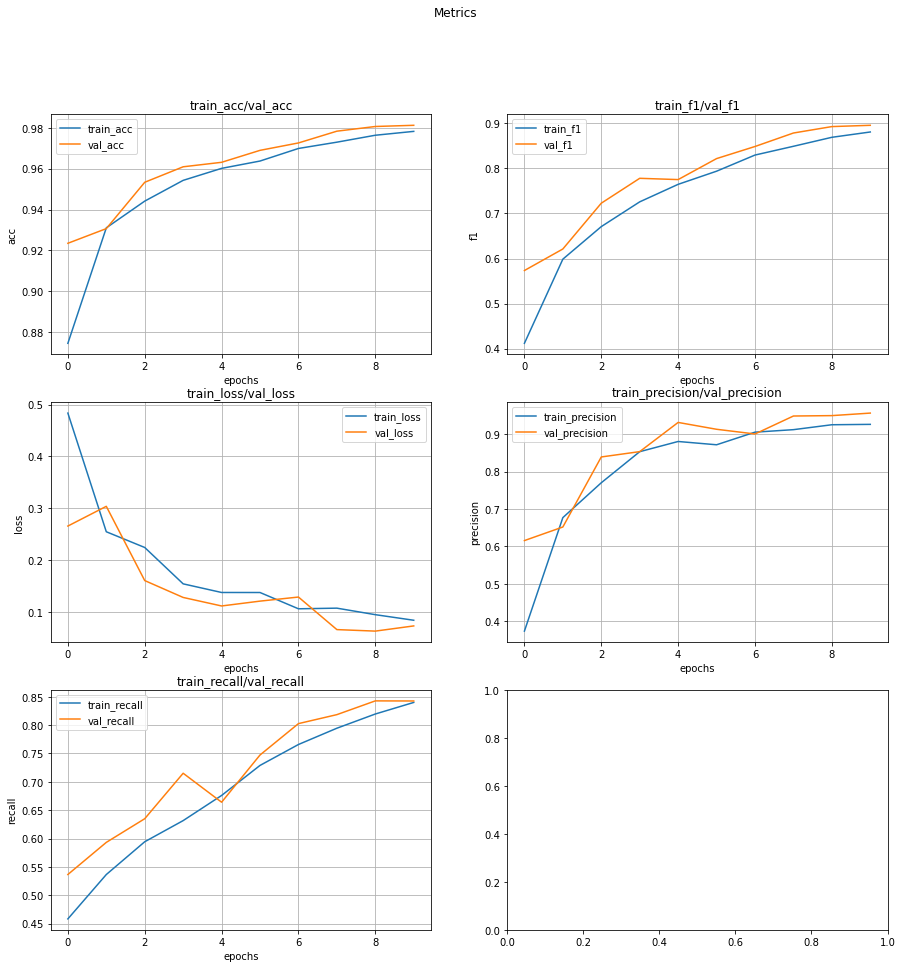

In [12]:
regression_trainer.history.plot()
plt.show()

In [13]:
class Conv1DBlock(nn.Module):
    def __init__(self, c_in, c_out, kernel_size=3, padding=(0, 0), stride=1, max_pool=True):
        super(Conv1DBlock, self).__init__()
        self.padding = nn.ConstantPad1d(padding, 0)
        self.conv = nn.Conv1d(c_in, c_out, kernel_size=kernel_size, stride=stride, padding=0)
        self.batch_norm = nn.BatchNorm1d(c_out)
        self.act = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool1d(2) if max_pool else None
    
    def forward(self, x):
        x = self.act(self.batch_norm(self.conv(self.padding(x))))
        if self.max_pool is not None:
            x = self.max_pool(x)
        return x

class Conv1DSuperBlock(nn.Module):
    def __init__(self, c_in, c_out, kernel_sizes=[3], padding=[(0, 0)], stride=1, max_pool=True):
        super(Conv1DSuperBlock, self).__init__()
        assert(len(padding) == len(kernel_sizes))
        self.convs = [Conv1DBlock(c_in, c_out, kernel_size=k, padding=p, stride=stride, max_pool=max_pool)
                      for k, p in zip(kernel_sizes, padding)]
    
    def to(self, device):
        super(Conv1DSuperBlock, self).to(device)
        for conv in self.convs:
            conv.to(device)
        
    
    def forward(self, x):
        outputs = [conv(x) for conv in self.convs]
        return torch.cat(outputs, dim=1)
    

class ConvModel(nn.Module):
    def __init__(self, embedding_dim=50):
        super(ConvModel, self).__init__()
        self.embeddings = nn.Embedding(len(train_ds.vocab), embedding_dim=embedding_dim, padding_idx=train_ds.vocab[train_ds.vocab.pad])
        self.convs = nn.Sequential(Conv1DSuperBlock(embedding_dim, 32, [1,2,3], [(0, 0), (1, 0), (2, 0)]),
                                   Conv1DSuperBlock(32*3, 16, [1,2,3], [(0, 0), (1, 0), (2,0)]),
                                   Conv1DBlock(16*3, 20, 3, padding=(1,1), stride=1, max_pool=False),
                                   nn.AdaptiveMaxPool1d(1),
                                   nn.Flatten(),
                                   nn.Linear(20, 10),
                                   nn.ReLU(),
                                   nn.Dropout(0.5),
                                   nn.Linear(10, 1))
        
    def to(self, device):
        super(ConvModel, self).to(device)
        self.embeddings.to(device)
        self.convs[0].to(device)
        self.convs[1].to(device)
        self.convs[2].to(device)
        
    def forward(self, x, lens):
        x = self.embeddings(x)
        x = x.transpose(-1, 1)
        x = self.convs(x)
        return x.view(-1)

In [14]:
conv_model = ConvModel(100)

In [15]:
conv_trainer = SupervisedTrainer(conv_model,
                                 criterion='binary_cross_entropy_wl',
                                 optimizer='adam',
                                 acc_meters=['binary_with_logits_accuracy',
                                              Precision(with_logits=True),
                                              Recall(with_logits=True),
                                              F1Score(with_logits=True)],
                                 callbacks=[ProgbarLogger(notebook=True)])
conv_trainer.to('cuda')
conv_trainer.train(train_dl, val_dl, epochs=10)

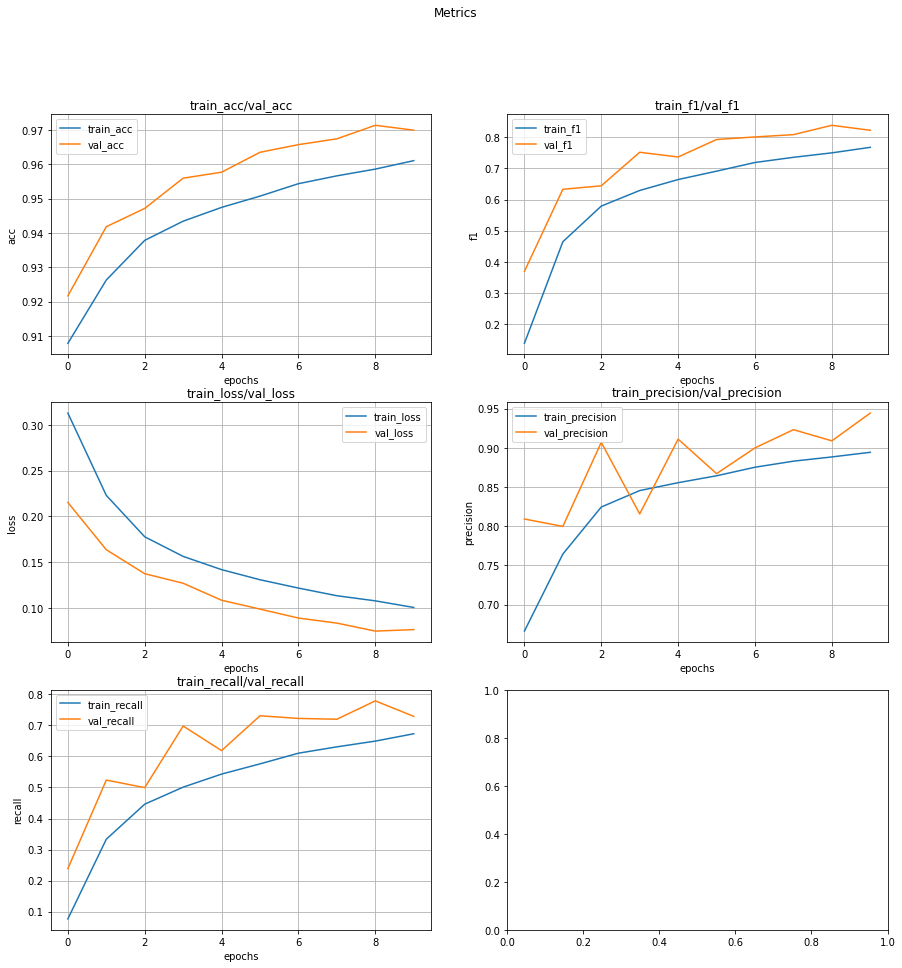

In [16]:
conv_trainer.history.plot()
plt.show()